# XMHW tests on the OFAM3 dataset

Purpose
-------
    The following will investigate the capability of xmhw to parallelise the MHW analysis on a subset of temperature data from the OFAM3 - 10th degree resolution global simulation from 1980-2100. The simulation runs from 1980 to 2006 under JRA55 atmospheric forcing, and thereafter the reanalysis is repeated but with the addition of the RCP8.5 climate trend.

    Contents:
        1. Load in Temperature Data and visualise (2D in space, 1D in time)
        2. Select the region around Australia to perform the heatwave analysis and throw rest away
        3. Calculate the climatology required for the heatwave analysis and save as a new netcdf file
            [ this will be read in later and in a new session for performing the heatwave analysis ]
        4. Perform heatwave analysis using xmhw by iterating around the subsetted grid

Thanks to John Reilly for sharing his [code](https://github.com/Thomas-Moore-Creative/shared_sandbox/blob/main/mhw-3d-scalingTests-gadiJup.ipynb)
    


### imports

In [1]:
import sys
import os

### data handling
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import numpy_groupies as npg 

### plotting
import matplotlib.pyplot as plt
#from matplotlib import ticker
#from matplotlib.gridspec import GridSpec
#import matplotlib.colors as mcolors
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import cmocean.cm as cmo
#from cmocean.tools import lighten

### flox for GroupBy Reductions
from flox import Aggregation
from flox.aggregations import mean
import flox.xarray

### marine heatwaves python package
#from xmhw.xmhw import threshold, detect

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
#print("cmocean version =", sys.modules[cmo.__package__].__version__)
#print("cartopy version =", sys.modules[ccrs.__package__].__version__)

python version = 3.10.
numpy version = 1.23.5
pandas version = 2.2.2
xarray version = 2024.3.0
scipy version = 1.12.0
matplotlib version = 3.8.4
cmocean version = v3.0.3
cartopy version = 0.23.0


### remove warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

### import the dask client for assessing performance

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45549/status,
Dashboard: /proxy/45549/status,Workers: 14
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45729,Workers: 14
Dashboard: /proxy/45549/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:44411,Total threads: 2
Dashboard: /proxy/35339/status,Memory: 17.94 GiB
Nanny: tcp://127.0.0.1:38525,


### Functions

In [ ]:
# preprocesser to drop unwanted variables
def drop_stuff(ds, coords_to_drop,vars_to_drop):
    """
    Preprocessor function to drop specified coordinates and variables from a dataset loaded via xr.open_mfdataset

    Parameters:
        ds (xarray.Dataset): The dataset from which coordinates & variables are to be dropped.
        coords_to_drop (list of str): List of coordinate names to drop.
        vars_to_drop(list of str): List of variable names to drop

    Returns:
        xarray.Dataset: Dataset with specified coordinates and variables dropped.
    """
    # Drop coordinates if they are in the dataset
    ds = ds.drop_vars(coords_to_drop, errors='ignore')
    ds = ds.drop_vars(vars_to_drop, errors='ignore')
    return ds

In [ ]:
def print_chunks(data_array):
    ''' 
    Print the chunk sizes for each dimension in an Xarray dataset
    
    Parameters: 
    data_array (xarray.Daraset): The dataset from which to print chunks
    '''
    # Get chunk size
    chunks = data_array.chunks
    # Get dimension names
    dim_names = data_array.dims
    
    readable_chunks = {dim: chunks[i] for i, dim in enumerate(dim_names)}
    
    # Print chunk sizes for each dimension
    for dim, sizes in readable_chunks.items():
        print(f"{dim} chunks: {sizes}")

### Creating Custom Aggragation

In [ ]:
# Define the custom grouped reduction function
def grouped_nanpercentile_90(group_idx, array, *, axis=-1, size=None, fill_value=None, dtype=None):
    """
    Compute the 90th percentile for grouped data, skipping NaNs.

    Parameters:
    group_idx (np.ndarray, 1D): Integer codes for group labels (1D).
    array (np.ndarray, nD): Values to reduce (nD).
    axis (int, optional): Axis of array along which to reduce. Requires array.shape[axis] == len(group_idx).
    size (int, optional): Expected number of groups. If None, output.shape[-1] == number of uniques in group_idx.
    fill_value (optional): Fill value for when the number of groups in group_idx is less than size.
    dtype (optional): Data type of output.

    Returns:
    np.ndarray: An array with the 90th percentile value for each group, shape determined by `size`.
    """
    return npg.aggregate_numpy.aggregate(
        group_idx,
        array,
        func=lambda x: np.nanpercentile(x, 90),
        axis=axis,
        size=size,
        fill_value=fill_value,
        dtype=dtype,
    )

In [ ]:
# Create the Aggregation
agg_nanpercentile_90 = Aggregation(
    name="nanpercentile_90",
    numpy=grouped_nanpercentile_90,
    fill_value=np.nan,  
    chunk=None,  
    combine=None, 
)

agg_nanpercentile_90

## Load SST data

In [3]:
# Retrieving historical temperature data from fp2
wrkdir = "/g/data/fp2/OFAM3"

In [ ]:
%%time

# Define coordinates and variables to drop
coords_to_drop =['st_edges_ocean','nv']
vars_to_drop =['Time_bounds','average_DT','average_T1','average_T2']

# Load the datasets with preprocessing
big_sst = xr.open_mfdataset(
    [wrkdir, "/jra55_historical.1/surface/ocean_temp_sfc_*.nc"], 
    parallel=True, 
    preprocess = lambda x: drop_stuff(x, 
                                         coords_to_drop, 
                                         vars_to_drop)).squeeze() #combine='by_coords' is default

# Rename Time to time
big_sst = big_sst.rename({'Time':'time'})

big_sst

### Plot 

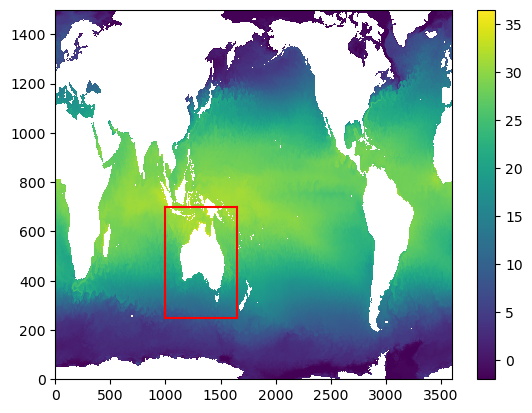

In [4]:
# Variables defining the boundaries
x1, x2 = 1000, 1650
y1, y2 = 250, 700

# Variable to plot
temp = big_sst['temp']

# Plotting
plt.figure()
plt.pcolormesh(temp.isel(time=0))
plt.colorbar()

# Plotting the boundaries
plt.plot([x1,x1],[y1,y2], 'r-')
plt.plot([x2,x2],[y1,y2], 'r-')
plt.plot([x1,x2],[y1,y1], 'r-')
plt.plot([x1,x2],[y2,y2], 'r-')

## subset the data around the australian continent

In [5]:
# Subset the dataset around the Australian continent
sst = big_sst.isel(yt_ocean=slice(y1,y2), 
                            xt_ocean=slice(x1,x2)).drop_vars('st_ocean')
sst

<xarray.DataArray 'temp' (time: 13149, yt_ocean: 450, xt_ocean: 650)> Size: 15GB
array([[[ 7.142704 ,  7.117527 ,  7.088993 , ..., 11.56728  ,
         11.614277 , 11.679737 ],
        [ 7.1443825,  7.132633 ,  7.0973854, ..., 11.667988 ,
         11.74688  , 11.844234 ],
        [ 7.1443825,  7.132633 ,  7.1007423, ..., 11.763664 ,
         11.866055 , 11.990265 ],
        ...,
        [31.343578 , 31.343578 , 31.336864 , ..., 31.197546 ,
         31.15894  , 31.120335 ],
        [31.409039 , 31.404003 , 31.387218 , ..., 31.246223 ,
         31.219368 , 31.184118 ],
        [31.46611  , 31.449324 , 31.420788 , ..., 31.254616 ,
         31.237831 , 31.214333 ]],

       [[ 7.1410255,  7.1225624,  7.0940285, ..., 11.557205 ,
         11.602528 , 11.664631 ],
        [ 7.149418 ,  7.1343117,  7.1057777, ..., 11.661274 ,
         11.740166 , 11.839199 ],
        [ 7.1510963,  7.120884 ,  7.0906715, ..., 11.765343 ,
         11.87109  , 11.998657 ],
...
        [29.926908 , 29.950407 , 29.972229 , ..., 31.195868 ,
         31.286507 , 31.308329 ],
        [29.913479 , 29.93698  , 29.957123 , ..., 31.189154 ,
         31.278114 , 31.274757 ],
        [29.9118   , 29.93698  , 29.955444 , ..., 31.163975 ,
         31.236153 , 31.26133  ]],

       [[ 6.5048676,  5.880459 ,  5.5027924, ..., 11.104008 ,
         11.151005 , 11.203041 ],
        [ 6.5082245,  5.914028 ,  5.5313263, ..., 11.211433 ,
         11.27018  , 11.335644 ],
        [ 6.59383  ,  6.1355934,  5.7562485, ..., 11.347393 ,
         11.429638 , 11.513565 ],
        ...,
        [29.839626 , 29.869839 , 29.895016 , ..., 31.268044 ,
         31.321756 , 31.326792 ],
        [29.831234 , 29.866482 , 29.893337 , ..., 31.274757 ,
         31.301615 , 31.298258 ],
        [29.83459  , 29.876553 , 29.908443 , ..., 31.259651 ,
         31.28315  , 31.279793 ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 105kB 1979-01-01T12:00:00 ... 2014-12-31T...
  * xt_ocean  (xt_ocean) float64 5kB 100.1 100.2 100.2 ... 164.8 164.9 164.9
  * yt_ocean  (yt_ocean) float64 4kB -49.95 -49.85 -49.75 ... -5.25 -5.15 -5.05
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [6]:
print("Historical SST dataset = %i Gb"%(big_sst.nbytes/1e9))


Historical SST dataset = 15 Gb


In [ ]:
# Print size of reduced dataset
print("reduced historical SST dataset = %i Gb"%(sst.nbytes/1e9))

### Create DOY index

In [ ]:
sst['doy'] = sst['time'].dt.dayofyear
doy

## iterate around the australian continent and compute the heatwaves

### calculate the climatology
    which we will use later for calculating the marine heatwaves in a subsequent step

### Identify SST chunks for full dataset

In [1]:
# Print chunk sizes for each dimension of temp
print_chunks(temp)

NameError: name 'print_chunks' is not defined

## Implementing Flox for GroupBY Aggregations 

In [ ]:
# Group the subset by DOY and take the mean using the cohort method, no chunking 
climatology_cohorts = flox.xarray.xarray_reduce(
    sst,
    doy,
    func="mean",
    method="cohorts",
)

In [ ]:
# Print the number of tasks in the Dask graph 
num_tasks = len(climatology_cohorts.data.dask)
print(f"Number of tasks for cohorts w/o chunking : {num_tasks}")

#### 28 x 32GB workers - megamem queue - Wall time: 9min 47s

In [ ]:
%%time
# client = Client(threads_per_worker=1) ## 28 x 32GB workers - megamem queue
climatology_cohorts = climatology_cohorts.compute()

In [ ]:
print(climatology_cohorts.nbytes/1e9)

In [ ]:
%%time

# Group the subset by DOY and take the quantile using the blockwise method, no chunking 
threshold_cohorts = flox.xarray.xarray_reduce(
    sst,
    doy,
    func=agg_nanpercentile_90, 
    method="blockwise", 
)

threshold_cohorts

In [ ]:
# Print the number of tasks in the Dask graph 
num_tasks = len(threshold_cohorts.data.dask)
print(f"Number of tasks for cohorts w/o chunking : {num_tasks}")

In [ ]:
%%time
#XXL-mem normal queue
threshold_cohorts = threshold_cohorts.compute()

In [7]:
# %%time

# sst['doy'] = sst['time'].dt.dayofyear
# sst = sst.chunk({"time":-1, "yt_ocean":10, "xt_ocean":10})
# sst


CPU times: user 2.49 s, sys: 66.9 ms, total: 2.56 s
Wall time: 2.18 s


<xarray.DataArray 'temp' (time: 13149, yt_ocean: 450, xt_ocean: 650)> Size: 15GB
dask.array<xarray-<this-array>, shape=(13149, 450, 650), dtype=float32, chunksize=(13149, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 105kB 1979-01-01T12:00:00 ... 2014-12-31T...
  * xt_ocean  (xt_ocean) float64 5kB 100.1 100.2 100.2 ... 164.8 164.9 164.9
  * yt_ocean  (yt_ocean) float64 4kB -49.95 -49.85 -49.75 ... -5.25 -5.15 -5.05
    doy       (time) int64 105kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

### calculate the daily climatology and 90th percentile threshold to define a MHW

In [8]:
# %%time

# ii = 0
# jj = 0
# di = 50
# dj = 50

# print("Calculating the climatology and threshold")
# seas_list = []
# thresh_list = []
# for ii in np.arange(0,len(sst.coords['xt_ocean']),di):
#     print(ii)
#     for jj in np.arange(0,len(sst.coords['yt_ocean']),dj):
#         tmp = sst.isel(xt_ocean=slice(ii,ii+di), yt_ocean=slice(jj,jj+dj))
#         seas_list.append(tmp.groupby('doy').mean(dim='time').compute())
#         thresh_list.append(tmp.groupby('doy').quantile(0.9, dim='time', skipna=True).compute())

        
# ### merge the lists into single xarrays with the results
# print("Merging results")
# seas_new = xr.merge(seas_list)
# thresh_new = xr.merge(thresh_list)


Calculating the climatology and threshold
0
50
100
150
200
250
300
350
400
450
500
550
600
Merging results
CPU times: user 10min 51s, sys: 7min 56s, total: 18min 48s
Wall time: 17min 25s


### perform rolling mean average (moving window) across the time dimension and snip ends

In [9]:
# Pad and apply rolling mean window of size 31 along DOY
climatology = climatology_cohorts.pad(doy=(31-1)//2, mode='wrap').rolling(doy=31, center=True).mean()
threshold90 = threshold_cohorts.pad(doy=(31-1)//2, mode='wrap').rolling(doy=31, center=True).mean(skipna=True)

# Chunk the data and select a subset along DOY
climatology = climatology_cohorts.chunk({'doy':-1, 'yt_ocean':50, 'xt_ocean':50}).isel(doy=slice(15,-15))
threshold90 = threshold_cohorts.chunk({'doy':-1, 'yt_ocean':50, 'xt_ocean':50}).isel(doy=slice(15,-15)).drop_vars('quantile')

In [10]:
print("Size (Mb) of daily climatology = %i"%(climatology.nbytes/1e6))
print("Size (Mb) of daily threshold90 = %i"%(threshold90.nbytes/1e6))

Size (Mb) of daily climatology = 428
Size (Mb) of daily threshold90 = 856


### save to disk

In [11]:
%%time
os.chdir("/g/data/es60/pjb581/heatwaves")
os.getcwd()

print("Saving climatology and threshold to disk")
climatology.to_netcdf('Australian_SST_daily_climatology.nc', mode='w')
threshold90.to_netcdf('Australian_SST_daily_MHWthreshold.nc', mode='w')


Saving climatology and threshold to disk


PermissionError: [Errno 13] Permission denied: b'/g/data/es60/pjb581/heatwaves/Australian_SST_daily_climatology.nc'